In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle competitions download -c rsna-2024-lumbar-spine-degenerative-classification

100% 28.2G/28.2G [06:16<00:00, 121MB/s]
100% 28.2G/28.2G [06:16<00:00, 80.4MB/s]


In [3]:
import zipfile
with zipfile.ZipFile('rsna-2024-lumbar-spine-degenerative-classification.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [4]:
pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 27.1 MB/s eta 0:00:00


In [5]:
import os
import numpy as np
import pydicom
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
import gc
import psutil

In [6]:
import os
import numpy as np
import pydicom
from tensorflow.keras.preprocessing.image import img_to_array

# Function to load and preprocess the images
def load_dcm_image(filepath, target_size=(224, 224)):
    try:
        dcm = pydicom.dcmread(filepath)
        img = dcm.pixel_array.astype(float)

        # Resize the image to the target size (224x224)
        img = np.resize(img, target_size)

        # Normalize the image to [0, 1]
        img = (img - np.min(img)) / (np.max(img) - np.min(img))

        # Ensure the image has a single channel (grayscale)
        img = np.expand_dims(img, axis=-1)

        return img
    except Exception as e:
        print(f"Error processing image {filepath}: {e}")
        return None

# Limit the number of images to load for debugging
max_images_to_load = 2000

images = []
labels = []

train_images_dir = '/content/train_images'  # Directory where your images are stored

# Loading a limited number of images for debugging
image_count = 0
for root, dirs, files in os.walk(train_images_dir):
    for filename in files:
        if filename.endswith('.dcm'):
            if image_count >= max_images_to_load:
                break
            img_path = os.path.join(root, filename)
            img = load_dcm_image(img_path)

            # If the image is valid (not None), append to the list
            if img is not None:
                images.append(img)
                labels.append(0)  # Replace with actual label if available

            image_count += 1
        if image_count >= max_images_to_load:
            break

print(f"Total images loaded: {len(images)}")
print(f"Total labels loaded: {len(labels)}")

# Convert the images list to a NumPy array
# Ensure all images are the same shape before converting
images = np.array(images)
labels = np.array(labels)

# Check the shape of the images array
print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")

# Check if the images array is empty or not properly loaded
if images.size == 0:
    raise ValueError("No valid images were loaded.")

# If everything is correct, the images should have the same shape (e.g., (224, 224, 1))


Total images loaded: 2000
Total labels loaded: 2000
Images shape: (2000, 224, 224, 1)
Labels shape: (2000,)


In [7]:
# 80% train, 10% validation, 10% test
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set shape: {X_train.shape}, Validation set shape: {X_val.shape}, Test set shape: {X_test.shape}")

# Image Preprocessing
def preprocess_images(images, target_size=(224, 224)):
    preprocessed_images = []
    for img in images:
        img = np.resize(img, target_size + (1,))  # Resize images
        img = img_to_array(img)  # Convert to array
        img = img / 255.0  # Normalize to range [0, 1]
        preprocessed_images.append(img)
    return np.array(preprocessed_images)

X_train = preprocess_images(X_train)
X_val = preprocess_images(X_val)
X_test = preprocess_images(X_test)


Training set shape: (1600, 224, 224, 1), Validation set shape: (200, 224, 224, 1), Test set shape: (200, 224, 224, 1)


In [8]:
# Image Augmentation for training set
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,

)

In [9]:
# Validation and Test data augmentation should be minimal (only rescaling)
val_test_datagen = ImageDataGenerator(rescale=1./255)

Convolutional Neural Network (CNN) with L2 regularization and Dropout for the classification of lumbar spine images. You've also incorporated Image Augmentation for training and a simple train-validation-test split

80% for training

10% for validation

10% for testing

In [10]:
# Create a CNN model with L2 regularization and Dropout
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1), kernel_regularizer=l2(0.001)),  # L2 regularization
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Dropout layer to prevent overfitting
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [28]:
# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [31]:
import time

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Start timing
start_time = time.time()

# Train the model (replace `train_data` and `train_labels` with your data)
history = model.fit(train_datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_val, y_val),
                    epochs=10)
# End timing
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time
print(f"Training time: {elapsed_time:.2f} seconds")


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 196s 4s/step - accuracy: 1.0000 - loss: 8.3061e-07 - val_accuracy: 1.0000 - val_loss: 7.5099e-09
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 190s 4s/step - accuracy: 1.0000 - loss: 3.3868e-09 - val_accuracy: 1.0000 - val_loss: 3.8931e-11
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 199s 4s/step - accuracy: 1.0000 - loss: 6.8060e-11 - val_accuracy: 1.0000 - val_loss: 1.5165e-12
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 190s 4s/step - accuracy: 1.0000 - loss: 1.2460e-10 - val_accuracy: 1.0000 - val_loss: 5.2929e-15
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 188s 4s/step - accuracy: 1.0000 - loss: 1.0395e-10 - val_accuracy: 1.0000 - val_loss: 2.5296e-15
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 210s 4s/step - accuracy: 1.0000 - loss: 1.4847e-10 - val_accuracy: 1.0000 - val_loss: 9.3818e-13
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 249s 4s/step - accuracy: 1.0000 - loss: 1.2263e-11 - val_accuracy: 1.0000 - val_loss: 7.0655e-15
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 195s 4s/step - accuracy: 1.0

In [32]:
elapsed_minutes = elapsed_time / 60
print(f"Training time: {elapsed_minutes:.2f} minutes")

Training time: 33.45 minutes


In [33]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))


In [34]:
model.save('lumbar_spine_model.h5')

In [35]:
# Evaluate on the test set (separate data that was not used in training or validation)
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}, Test Loss: {test_loss}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 844ms/step - accuracy: 1.0000 - loss: 8.2602e-16
Test Accuracy: 1.0, Test Loss: 8.260177421955659e-16


To validate the performance and check for potential issues (like overfitting, data leakage, or poor generalization)

In [36]:
# Evaluate on the validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=1)

print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation Loss: {val_loss}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 758ms/step - accuracy: 1.0000 - loss: 8.2602e-16
Validation Accuracy: 1.0
Validation Loss: 8.260177421955659e-16


In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

Training loss should be decreased

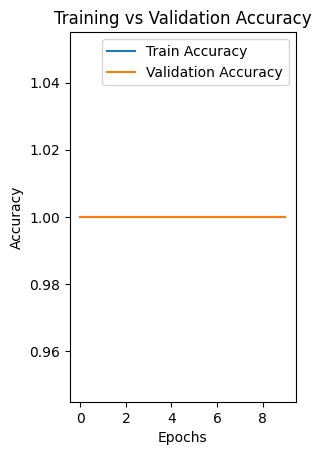

In [39]:
# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

Validation loss and accuracy should ideally improve along with training loss

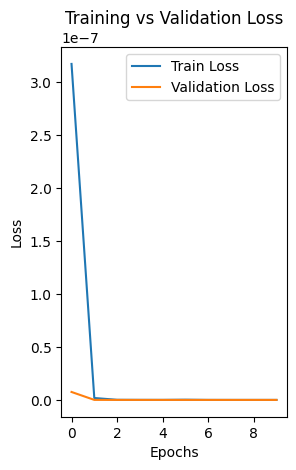

In [40]:
# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,168,515 (42.60 MB)

 Trainable params: 11,168,513 (42.60 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [21]:
# prompt: find accuracy for test data above model

val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 779ms/step - accuracy: 1.0000 - loss: 5.2276e-05
Validation Accuracy: 100.00%


Class 0: Could represent "No Disease"

Class 1: Could represent "Disease Present"

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


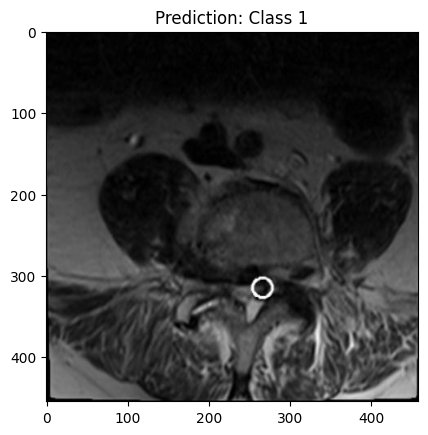

Prediction: Class 1


In [24]:
import numpy as np
import pydicom
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load the trained model
model = load_model('lumbar_spine_model.h5')

# Function to preprocess a DICOM image
def preprocess_dcm_image(image_path, target_size=(224, 224)):
    # Load the DICOM image
    dcm = pydicom.dcmread(image_path)
    img = dcm.pixel_array.astype(float)

    # Resize the image to the target size
    img = np.resize(img, target_size)

    # Normalize the image to [0, 1]
    img = (img - np.min(img)) / (np.max(img) - np.min(img))

    # Ensure the image has a single channel (grayscale)
    img = np.expand_dims(img, axis=-1)

    # Add batch dimension (1, 224, 224, 1)
    img = np.expand_dims(img, axis=0)
    return img

# Path to the DICOM image you want to test
image_path = '/content/Screenshot 2024-11-10 191118.dicom'  # Update this path with the actual file path

# Preprocess the DICOM image
preprocessed_img = preprocess_dcm_image(image_path)

# Predict the class of the new image
prediction = model.predict(preprocessed_img)

# Display the DICOM image
dcm = pydicom.dcmread(image_path)
img = dcm.pixel_array
plt.imshow(img, cmap='gray')
plt.title(f"Prediction: {'Class 1' if prediction[0] < 0.5 else 'Class 0'}")
plt.show()

# Print the prediction
print(f"Prediction: {'Class 1' if prediction[0] < 0.5 else 'Class 0'}")


In [41]:
import os
import pydicom
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [42]:
def load_dcm_image(filepath):
    dcm = pydicom.dcmread(filepath)
    img = dcm.pixel_array.astype(float)
    img = (img - np.min(img)) / (np.max(img) - np.min(img))  # Normalize
    img = np.expand_dims(img, axis=-1)  # Adding a channel dimension (grayscale)
    img_resized = resize_image(img)  # Resize the image (e.g., 224x224)
    return img_resized

In [43]:
def resize_image(img, target_size=(224, 224)):
    return tf.image.resize(img, target_size)

In [44]:
def convert_gray_to_rgb(img):
    if img.ndim == 3 and img.shape[2] == 1:  # Check if grayscale
        img = np.repeat(img, 3, axis=-1)  # Convert (224, 224, 1) to (224, 224, 3)
    return img


In [45]:
def load_images_from_dir(train_images_dir, max_images=1000):
    images = []
    labels = []
    image_count = 0

    for root, dirs, files in os.walk(train_images_dir):
        for filename in files:
            if filename.endswith('.dcm'):
                filepath = os.path.join(root, filename)
                img = load_dcm_image(filepath)
                img_rgb = convert_gray_to_rgb(img)  # Ensure RGB format
                images.append(img_rgb)

                label = get_label_for_image(filepath)  # Replace with your label extraction logic
                labels.append(label)

                image_count += 1
                if image_count >= max_images:
                    print(f"Loaded {max_images} images. Stopping...")
                    return np.array(images), np.array(labels)

    return np.array(images), np.array(labels)

def get_label_for_image(filepath):
    # Example label extraction logic: replace with your actual logic
    return 0  # Placeholder, updat

In [47]:
train_images_dir = '/content/train_images'  # Update path if needed
images, labels = load_images_from_dir(train_images_dir, max_images=2000)

Loaded 2000 images. Stopping...


In [48]:
images = images / 255.0

In [49]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

In [50]:
# Convert labels to categorical if necessary (one-hot encoding for classification)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)  # Adjust num_classes accordingly
y_val = tf.keras.utils.to_categorical(y_val, num_classes=2)  # Adjust num_classes accordingly

In [51]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [52]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)  # Output layer (adjust the number of classes)

In [53]:
model = Model(inputs=base_model.input, outputs=predictions)


In [54]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [55]:
model.summary()


Model: "functional_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 26,211,714 (99.99 MB)

 Trainable params: 2,624,002 (10.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [56]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    epochs=10,  # Number of epochs can be adjusted
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

50/50 ━━━━━━━━━━━━━━━━━━━━ 411s 8s/step - accuracy: 1.0000 - loss: 0.0935 - val_accuracy: 1.0000 - val_loss: 7.7991e-05


In [57]:
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

13/13 ━━━━━━━━━━━━━━━━━━━━ 78s 6s/step - accuracy: 1.0000 - loss: 7.7992e-05
Validation Accuracy: 100.00%


In [58]:
predictions = model.predict(X_val)
predicted_labels = np.argmax(predictions, axis=1)

13/13 ━━━━━━━━━━━━━━━━━━━━ 88s 7s/step


In [59]:
import matplotlib.pyplot as plt


In [60]:
for layer in base_model.layers[-50:]:
    layer.trainable = True

In [61]:
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])


In [62]:
history_fine_tuned = model.fit(
    X_train, y_train,
    epochs=1,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

50/50 ━━━━━━━━━━━━━━━━━━━━ 650s 13s/step - accuracy: 1.0000 - loss: 0.0061 - val_accuracy: 1.0000 - val_loss: 9.2266e-05
